In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.listdir("/content/drive/MyDrive/Ham10000")


['HAM10000_metadata.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2']

In [ ]:
import os, shutil

part1 = "/content/drive/MyDrive/Ham10000/HAM10000_images_part_1"
part2 = "/content/drive/MyDrive/Ham10000/HAM10000_images_part_2"

all_images = "/content/drive/MyDrive/Ham10000/all_images"
os.makedirs(all_images, exist_ok=True)

for folder in [part1, part2]:
    for img in os.listdir(folder):
        shutil.copy(os.path.join(folder, img), os.path.join(all_images, img))

print("✅ Images combined successfully into all_images folder")


✅ Images combined successfully into all_images folder


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Ham10000/HAM10000_metadata.csv")
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf


In [ ]:
base_path = "/content/drive/MyDrive/Ham10000"

part1 = base_path + "/HAM10000_images_part_1"
part2 = base_path + "/HAM10000_images_part_2"
metadata = base_path + "/HAM10000_metadata.csv"

print("Part1 Images:", len(os.listdir(part1)))
print("Part2 Images:", len(os.listdir(part2)))
print("Metadata Found:", os.path.exists(metadata))


Part1 Images: 5011
Part2 Images: 5025
Metadata Found: True


In [ ]:
import shutil

all_images = base_path + "/all_images"
os.makedirs(all_images, exist_ok=True)

for folder in [part1, part2]:
    for img in os.listdir(folder):
        src = os.path.join(folder, img)
        dst = os.path.join(all_images, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("✅ All images combined into:", all_images)
print("Total images:", len(os.listdir(all_images)))


✅ All images combined into: /content/drive/MyDrive/Ham10000/all_images
Total images: 10036


In [ ]:
df = pd.read_csv(metadata)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df["label"] = df["dx"].apply(lambda x: 1 if x == "mel" else 0)

print(df["label"].value_counts())


label
0    8902
1    1113
Name: count, dtype: int64


In [ ]:
IMG_SIZE = 224

X = []
y = []

for i, row in df.iterrows():
    img_name = row["image_id"] + ".jpg"
    img_path = os.path.join(all_images, img_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    X.append(img)
    y.append(row["label"])

X = np.array(X) / 255.0
y = np.array(y)

print("✅ Images Loaded Successfully")
print("X shape:", X.shape)
print("y shape:", y.shape)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0

# ==============================
# PATHS
# ==============================
base_path = "/content/drive/MyDrive/Ham10000"
part1 = base_path + "/HAM10000_images_part_1"
part2 = base_path + "/HAM10000_images_part_2"
metadata = base_path + "/HAM10000_metadata.csv"

print("Metadata Found:", os.path.exists(metadata))
print("Part1 Images:", len(os.listdir(part1)))
print("Part2 Images:", len(os.listdir(part2)))

# ==============================
# COMBINE IMAGES INTO ONE FOLDER
# ==============================
import shutil

all_images = base_path + "/all_images"
os.makedirs(all_images, exist_ok=True)

for folder in [part1, part2]:
    for img in os.listdir(folder):
        src = os.path.join(folder, img)
        dst = os.path.join(all_images, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("✅ Total images in all_images:", len(os.listdir(all_images)))

# ==============================
# LOAD METADATA
# ==============================
df = pd.read_csv(metadata)

# mel = cancer, others = not cancer
df["label"] = df["dx"].apply(lambda x: 1 if x == "mel" else 0)

print("Label Counts:\n", df["label"].value_counts())

# ==============================
# LOAD IMAGES
# ==============================
IMG_SIZE = 224
X = []
y = []

for i, row in df.iterrows():
    img_name = row["image_id"] + ".jpg"
    img_path = os.path.join(all_images, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    X.append(img)
    y.append(row["label"])

X = np.array(X) / 255.0
y = np.array(y)

print("✅ Loaded Images Shape:", X.shape)

# ==============================
# TRAIN TEST SPLIT
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Test :", X_test.shape)

# ==============================
# CLASS WEIGHTS
# ==============================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weight_dict)

# ==============================
# DATA AUGMENTATION
# ==============================
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

# ==============================
# BUILD MODEL (EfficientNetB0)
# ==============================
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze base model initially
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ==============================
# TRAIN MODEL (FIRST TRAINING)
# ==============================
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weight_dict
)

# ==============================
# FINE TUNING (UNFREEZE LAST LAYERS)
# ==============================
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=10,
    class_weight=class_weight_dict
)

# ==============================
# EVALUATION
# ==============================
loss, acc = model.evaluate(X_test, y_test)
print("✅ Final Test Accuracy:", acc)

# ==============================
# SAVE MODEL
# ==============================
model.save("/content/drive/MyDrive/Ham10000/skin_cancer_high_accuracy_model.h5")
print("✅ Model Saved Successfully in Drive!")

# ==============================
# PLOT ACCURACY GRAPH
# ==============================
plt.plot(history.history["accuracy"], label="Train Accuracy (Phase 1)")
plt.plot(history.history["val_accuracy"], label="Val Accuracy (Phase 1)")
plt.plot(history2.history["accuracy"], label="Train Accuracy (FineTune)")
plt.plot(history2.history["val_accuracy"], label="Val Accuracy (FineTune)")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

# ==============================
# TEST PREDICTION
# ==============================
sample = X_test[0]
sample_input = np.expand_dims(sample, axis=0)

pred = model.predict(sample_input)[0][0]

plt.imshow(sample)
plt.title("Cancer (Melanoma)" if pred > 0.5 else "Not Cancer")
plt.axis("off")
plt.show()

print("Prediction Score:", pred)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metadata Found: True
Part1 Images: 5011
Part2 Images: 5025
✅ Total images in all_images: 10036
Label Counts:
 label
0    8902
1    1113
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# =======================
# PATHS
# =======================
base_path = "/content/drive/MyDrive/Ham10000"
metadata_path = base_path + "/HAM10000_metadata.csv"
image_folder = base_path + "/all_images"

# =======================
# LOAD CSV
# =======================
df = pd.read_csv(metadata_path)

# Cancer vs Not Cancer
df["label"] = df["dx"].apply(lambda x: "cancer" if x == "mel" else "not_cancer")

# Add image path
df["image"] = df["image_id"] + ".jpg"

# Train Test Split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

print("Train size:", len(train_df))
print("Test size :", len(test_df))

# =======================
# DATA AUGMENTATION
# =======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col="image",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_folder,
    x_col="image",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

# =======================
# MODEL (EfficientNetB0)
# =======================
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# =======================
# TRAINING
# =======================
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# =======================
# FINE TUNING
# =======================
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10
)

# =======================
# SAVE MODEL
# =======================
model.save("/content/drive/MyDrive/Ham10000/skin_cancer_model_best.h5")
print("✅ Model Saved Successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train size: 8012
Test size : 2003
Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 216s 779ms/step - accuracy: 0.8599 - loss: 0.3938 - val_accuracy: 0.8887 - val_loss: 0.3499
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 667ms/step - accuracy: 0.8873 - loss: 0.3607 - val_accuracy: 0.8887 - val_loss: 0.3500
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 167s 666ms/step - accuracy: 0.8835 - loss: 0.3631 - val_accuracy: 0.8887 - val_loss: 0.3510
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 669ms/step - accuracy: 0.8868 - loss: 0.3575 - val_accuracy: 0.8887 - val_loss: 0.3493
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 167s 667ms/step - accuracy: 0.8891 - loss: 0.3553 - val_accuracy: 0.8887 - val_loss: 0.3493
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 172s 684ms/step - accuracy: 0.8911 - loss: 0.3514 - val_accuracy: 0.8887 - val_loss: 0.3514
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 672ms/step - accuracy: 0.8864 - loss: 0.3606 - val_accuracy: 0.8887 - val_loss: 0.3493
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 674ms/step - accuracy: 0.8899 -

✅ Model Saved Successfully!


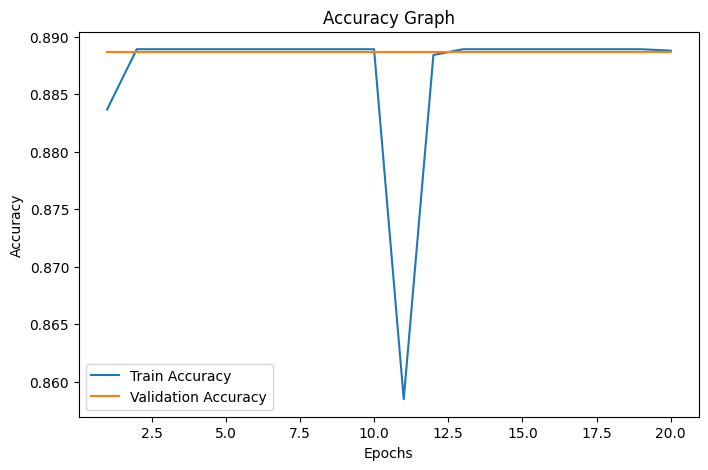

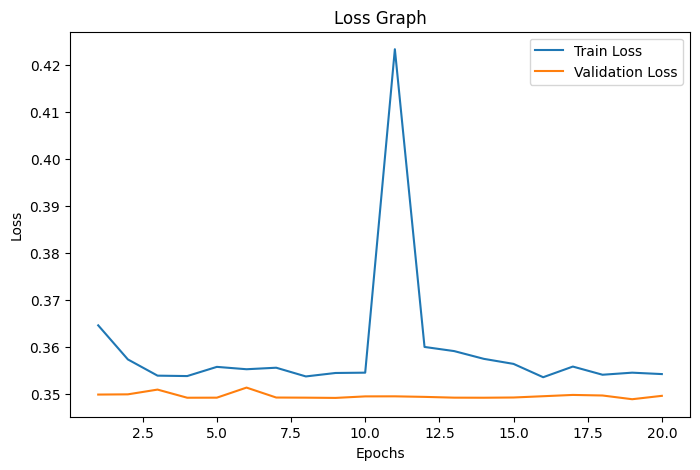

In [ ]:
import matplotlib.pyplot as plt

# Combine both histories (phase1 + phase2)
acc = history.history['accuracy'] + history2.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# True labels
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = cm.ravel()

print("✅ Confusion Matrix Values:")
print("TN (True Negative) :", tn)
print("FP (False Positive):", fp)
print("FN (False Negative):", fn)
print("TP (True Positive) :", tp)


63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step
✅ Confusion Matrix Values:
TN (True Negative) : 0
FP (False Positive): 223
FN (False Negative): 0
TP (True Positive) : 1780
